# Simulador de un sistema de comunicaciones digitales (Parte 2)

## Consigna:

Teniendo como referencia el esquema general de un sistema de comunicaciones digitales como el mostrado en la siguiente figura,

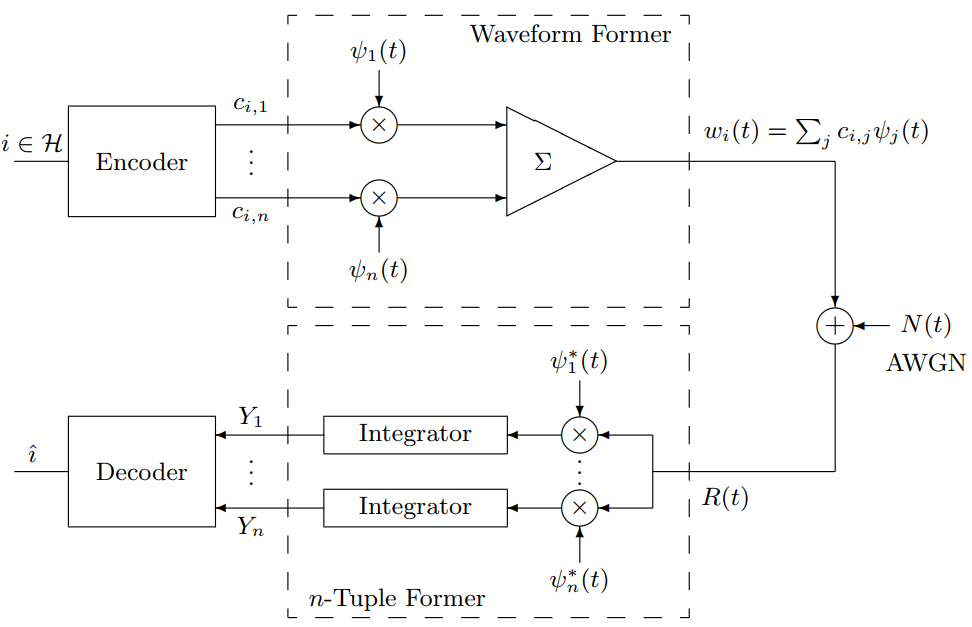

se pide realizar un simulador en una jupyter notebook que tenga las siguientes caracteristicas:

Transmisor conformado por:
- Generador de hipotesis binarias equiprobables,  $H=\{ 0,1 \}$. 
- Encoder con salida de palabra codigo binaria, $C=\{ -1,+1 \}$.
- Waveform Former con unica funcion base *"Raiz Coseno Realzado"*, donde a fines practico se va a considerar $t = n \Delta t$, con n definido como una secuencia de numeros enteros y  con $\Delta t$ definido como el periodo de muestreo. Suponer $T = 16 \Delta t$.

Canal modelado como:
- Canal $N(t)$ Gaussiano aditivo blanco de media cero y varianza parametrizable. El simulador tiene que tener la posibilidad de idealizar el canal.

El receptor conformado por:
- Un n-Tuple Former del tipo correlador (como el mostrado en la figura)
- Un n-Tuple Former del tipo matched filter  como el mostrado en la siguiente figura

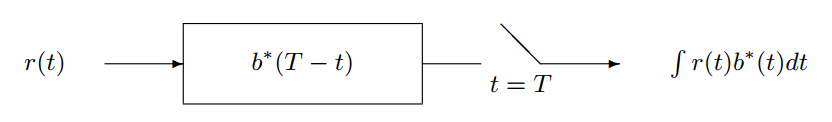

- Un decoder implementado con un criterio MAP
- Un decoder implementado con un criterio ML

Ademas agregar a la salida del sistema un bloque que permita calcular la probabilidad de error obtenida.

## Desarrollo:

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

### Transmisión

#### Generador y Encoder

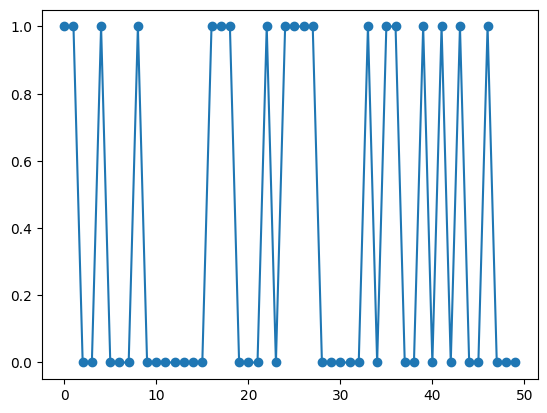

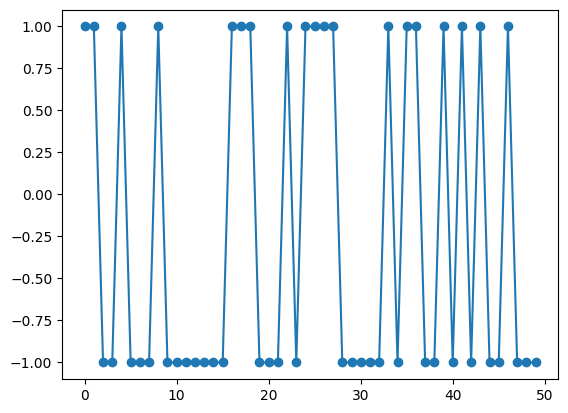

In [6]:
# Generador de Hipotesis Binarias
def Generador(threshold):
    if random.random() > threshold:
        return 1
    else:
        return 0

# Codificador de la Hipotesis Binaria
def Encoder(hipotesis, cod_1, cod_2):
    señal_cod = []
    for i in range(len(hipotesis)):
        if hipotesis[i] == 1:
            señal_cod.append(cod_1)
        else:
            señal_cod.append(cod_2)
                  
    return señal_cod

## Generacion de la Hipotesis Binaria 
samples = 100
ref = 0.5
hipotesis = [Generador(0.5) for i in range(samples)]

## Encoder - Codificación de la Hipotesis
codigo = Encoder(hipotesis, 1, -1)

plt.plot(hipotesis[0:50], marker='o')
plt.show()
plt.plot(codigo[0:50], marker='o')
plt.show()

#### Waveform Former

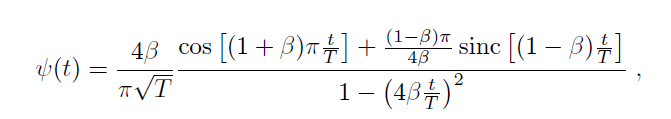

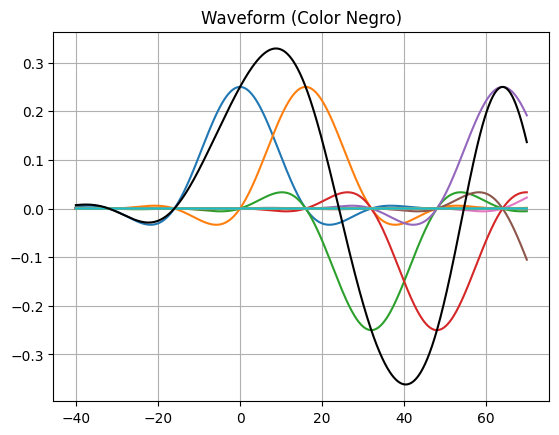

In [23]:
def RootRaisedCosine(t, beta, Ts,iT):
    return 1/np.sqrt(Ts) * np.sinc((t-iT)/Ts) * np.cos(np.pi*beta*(t-iT)/Ts) / (1 - (2*beta*(t-iT)/Ts) ** 2)

def WaveformFormer(simbolos, Beta, T, tt):
    sum_sig = 0
    signal = []

    for i in range(len(simbolos)):
        signal.append(simbolos[i] * RootRaisedCosine(tt,Beta,T,i*T))
        sum_sig += signal[i]
        plt.plot(tt,signal[i])
    
    return sum_sig  

# Parametros
T = 16  # Tiempo entre simbolos
Beta = 0.5  # Roll off
delta_t = np.arange(-40,70,0.1) #Eje del tiempo

waveform = WaveformFormer(codigo,Beta,T,delta_t)

plt.title("Waveform (Color Negro)")
plt.plot(delta_t,waveform, color = "black")
plt.grid()
plt.show()

### Canal

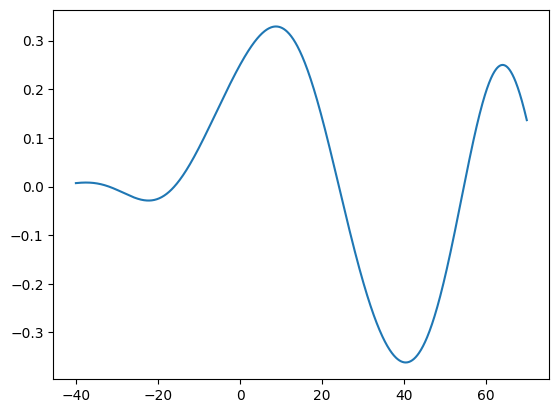

In [27]:
# Ruido Blanco Gaussiano
def WhiteNoise(waveform, media, varianza, IDEAL):
    if not IDEAL:
        ruido = np.random.normal(media, varianza, len(waveform))
        return waveform + ruido
    else:
        return waveform

## Ruido Blanco Gaussiano
media = 0
varianza = 0.2
IDEAL = True

SignalRuido = WhiteNoise(waveform, media, varianza**2, IDEAL)

## Grafico del efecto del Canal
plt.plot(delta_t,SignalRuido)
plt.show()

### Recepción

#### n-Tuple Former del tipo Correlador

In [28]:
def Correlador(SignalRuido, T, beta, tt):
    Señal_Receptor = []
    correlacion = []
    
    for i in range(0,len(SignalRuido),T):
        for j in range(i,i+T):
            correlacion += SignalRuido[j] * RootRaisedCosine(tt,beta,T,j*T)
    
        Señal_Receptor.append(correlacion)
    
    return Señal_Receptor
    
## N-Tuple former tipo Correlador
T = 16
Beta = 0.5
tt = np.arange(-40,70,0.1)
Señal_Receptor = Correlador(SignalRuido, T, Beta, tt)

ValueError: operands could not be broadcast together with shapes (0,) (1100,) 

#### n-Tuple Former del tipo matched filter

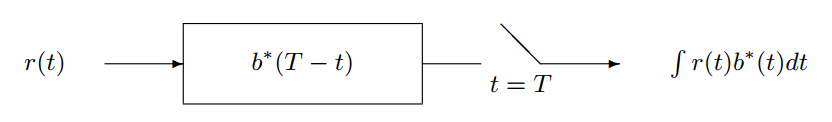

Teniendo en cuenta: $b^*(T-t) = \psi(-t+T)$

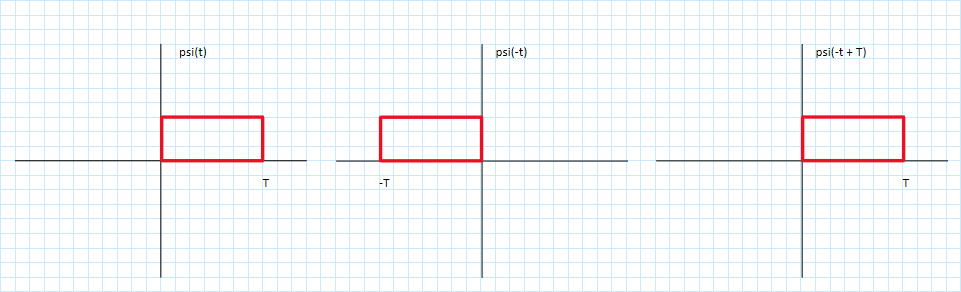

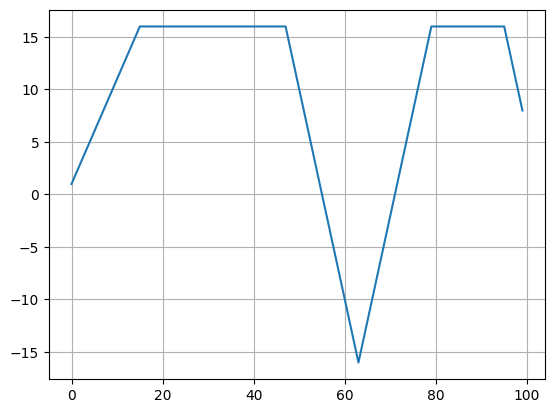

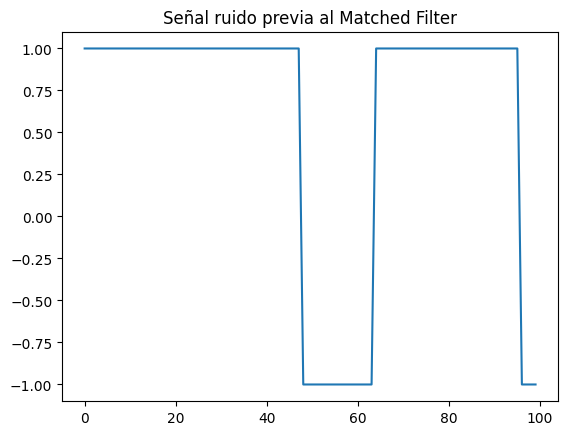

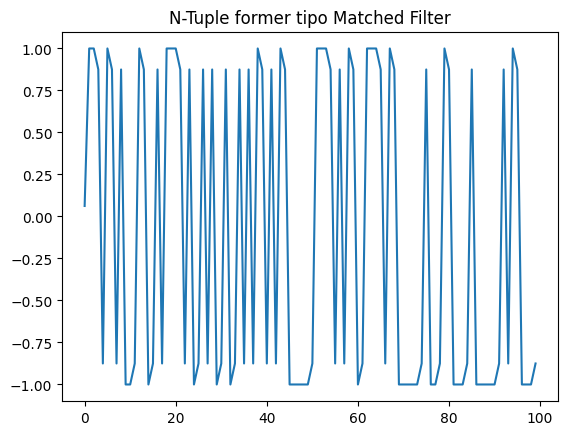

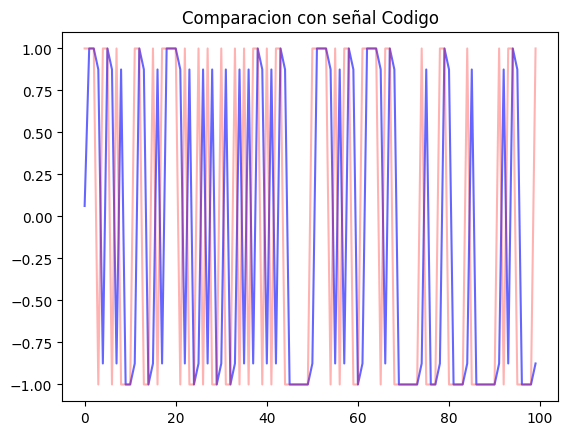

In [43]:
def MatchedFilter(señal, base, T, phase):
    convolucionada = np.convolve(señal, base)
    
    plt.plot(convolucionada[0:100])
    plt.grid()
    plt.show()
    
    muestras = [convolucionada[i]/T for i in range(phase, len(convolucionada), T+phase)]
    
    return muestras

## Matched Filter
base = np.ones(T)

Señal_Receptor_MF = MatchedFilter(SignalRuido, base, T, 0)

plt.title("Señal ruido previa al Matched Filter")
plt.plot(SignalRuido[0:100])
plt.show()
plt.title("N-Tuple former tipo Matched Filter")
plt.plot(Señal_Receptor_MF[0:100])
plt.show()
plt.title("Comparacion con señal Codigo")
plt.plot(Señal_Receptor_MF[0:100], color = "blue", alpha = 0.6)
plt.plot(codigo[0:100], color = "red", alpha = 0.3)
plt.show()

#### Decoder MAP

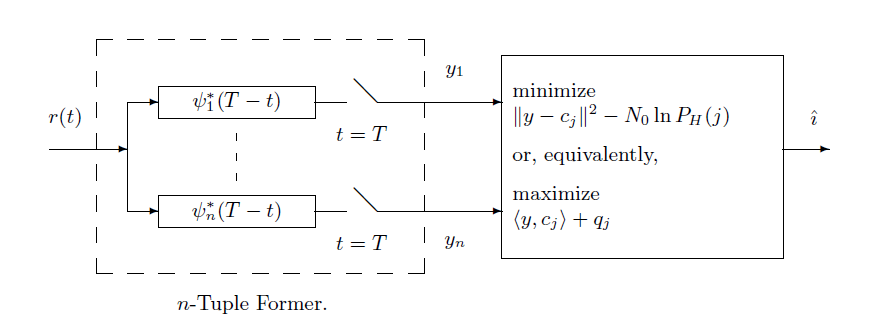

$\underset{i}\argmin{[\|y-c_i\|^2-\ln{f_H(i)\cdot2\sigma^2}]}$

Regla de decision MAP: y =  0.49906597000395714


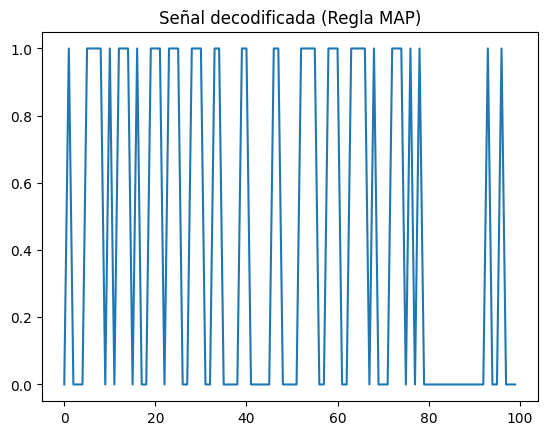

In [6]:
def ReglaDecisionMAP(señal, c_i, ph_i, sigma):
    valor = np.zeros(len(señal))
    
    for i in range(len(señal)):
        valor[i] = np.linalg.norm(señal[i]-c_i) ** 2 - np.log(ph_i) * 2*sigma**2
        
    return min(valor)

## Regla de Decision MAP
c_i = 1
ph_i = 0.5
sigma = varianza
decision_MAP = ReglaDecisionMAP(Señal_Receptor_MF, c_i, ph_i, sigma)

print("Regla de decision MAP: y = ", decision_MAP)

# ---- DECODIFICACION ----
def Decodificador(señal, threshold):
    hipotesis = []
    for i in range(len(señal)):
        if señal[i] > threshold:
            hipotesis.append(1)
        else:
            hipotesis.append(0)
    
    return hipotesis

señal_decodificada_MAP = Decodificador(Señal_Receptor_MF, decision_MAP)

plt.title("Señal decodificada (Regla MAP)")
plt.plot(señal_decodificada_MAP[0:100])
plt.show()

#### Decoder ML

Regla de decision ML: y =  0.0


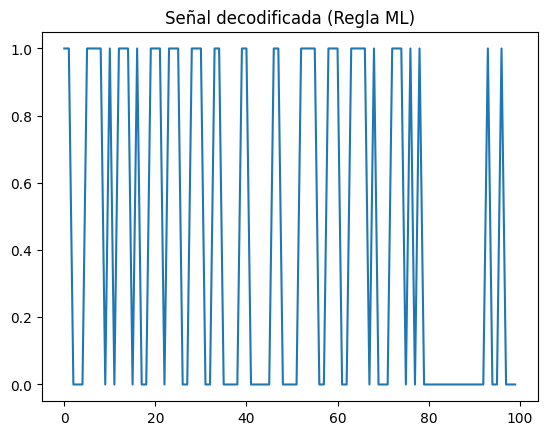

In [7]:
def ReglaDecisionML(c_1,c_2):
    return (c_1 + c_2) / 2

decision_ML = ReglaDecisionML(1, -1)
print("Regla de decision ML: y = ", decision_ML)

# ---- DECODIFICACION ----
señal_decodificada_ML = Decodificador(Señal_Receptor_MF, decision_ML)

plt.title("Señal decodificada (Regla ML)")
plt.plot(señal_decodificada_ML[0:100])
plt.show()

#### Error

In [8]:
def Error(señal, fuente, ph_0, ph_1):
    errores_0 = 0
    errores_1 = 0
    
    for i in range(len(fuente)):
        if señal[i] == 0 and fuente[i] == 1:
            errores_1 += 1
        elif señal[i] == 1 and fuente[i] == 0:
            errores_0 += 1
    
    return errores_0/len(fuente) * ph_0 + errores_1/len(fuente) * ph_1

error_MAP = Error(señal_decodificada_MAP, hipotesis, 0.5, 0.5)
print("Probabilidad de error total MAP: ", error_MAP)
error_ML = Error(señal_decodificada_ML, hipotesis, 0.5, 0.5)
print("Probabilidad de error total ML: ", error_ML)

Probabilidad de error total MAP:  0.248425
Probabilidad de error total ML:  0.24842
